# Evaluating Addition of Syntactic Information in Deep Learning Models for Sentiment Analysis
### Group 1 - Andrei Romascanu (260585208) - Stefan Wapnick (id 260461342)   

Exploring the effect of adding POS tag and parse tree information to pretrained word embeddings on text classification.

## Outline

1. Environment
2. Data  
  2.1 Load Data  
  2.2 Visualization  
  2.3 Preprocess (Spacy)  
  2.4 Validation split
3. Experiment Wrapper  
  3.1 Helper ClassesSequence Class  
  3.2 Experiment Data and Parameter Wrappers  
  3.3 Sequence Class  
  3.4 Model Factory  (hyperparameters, LSTM, #hidden units)   
  3.5 Experiment Wrapper (Training (parameters, saving model, calculating metrics, visualizations)  
4. Results Analysis
5. Run Experiment

# 1.0 Environment

Scripts to setup the environment (installation of packages, google drive data storage).

In [2]:
# mount google drive and upload datafiles
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# create working directory
import os
DATA_DIRECTORY = os.path.join('drive', 'My Drive', 'Comp550data')
if not os.path.exists(DATA_DIRECTORY):
  print("Making directory: {}".format(DATA_DIRECTORY))
  os.makedirs(DATA_DIRECTORY)

In [0]:
# upload files
upload_files = False
if upload_files:
  from google.colab import files
  uploaded = files.upload()

In [0]:
# install dependencies
!pip install --quiet "tensorflow>=1.7"
!pip install tensorflow-hub
!pip install seaborn
!pip install spacy
!pip install gensim
!pip install --upgrade pandas
!pip install pydot

    100% |████████████████████████████████| 13.9MB 3.1MB/s 
    100% |████████████████████████████████| 317kB 16.6MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Found existing installation: msgpack 0.6.0
    Uninstalling msgpack-0.6.0:
      Successfully uninstalled msgpack-0.6.0
    100% |████████████████████████████████| 8.9MB 4.0MB/s 
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
  Found existing installation: pandas 0.22.0
    Uninstalling pandas-0.22.0:
      Successfully uninstalled pandas-0.22.0


In [0]:
# import dependencies
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

import os
import pandas as pd
import math
from tqdm import tqdm
import contextlib


import gensim
import spacy
import re

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from tensorflow import keras
imdb = keras.datasets.imdb

In [0]:
import nltk
# download models
!python -m spacy download en_core_web_md


    100% |████████████████████████████████| 120.9MB 50.5MB/s 
  Running setup.py install for en-core-web-md ... - \ | / - \ | / - done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_md -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')



# 2.0 Data

Loading and preprocessing of data to extract additional POS and dependency parse tree linguistic information.

## 2.1 Load IMDB Data
Downloads the imdb movie review dataset, returning text sets for training and test.

In [0]:
# download data
from tensorflow import keras
imdb = keras.datasets.imdb

def load_imdb_dataset():
    """
    Downloads the imdb movie review dataset, returning text sets for training and test.
    """
    (train_data, train_labels), (test_data, test_labels) = imdb.load_data()

    # convert from integers to text
    word_index = imdb.get_word_index()
    word_index = {k: (v + 3) for k, v in word_index.items()}
    word_index["<PAD>"] = 0
    word_index["<START>"] = 1
    word_index["<UNK>"] = 2  # unknown
    word_index["<UNUSED>"] = 3

    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

    def decode_review(text):
        return ' '.join([reverse_word_index.get(i, '?') for i in text])

    train_x = [decode_review(x) for x in train_data]
    test_x = [decode_review(x) for x in test_data]
    return (train_x, train_labels), (test_x, test_labels)

## 2.2 Data Visualization
Utility functions for visualizing the dataset.
 - Graphs the frequency of sequence lengths among all text sequences
 - Calculates the out of vocabulary percentage for word embeddings (number of words that do not have a word embedding)

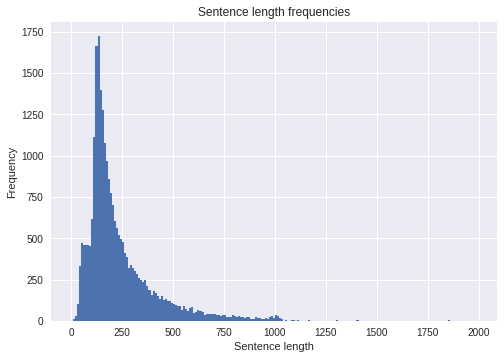

Mean: 238.714880
StdDev: 176.495815
Min: 11.000000
Max: 2494.000000



In [23]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_text_lengths(text_sequences):
    """
    Graphs the frequency of sequence lengths among all text sequences
    """
    sent_word_counts = [len(x.split()) for x in text_sequences]
    _ = plt.hist(sent_word_counts, bins=[10 * x for x in range(200)])

    plt.title("Sentence length frequencies")
    plt.xlabel('Sentence length')
    plt.ylabel('Frequency')
    plt.show()

    print("Mean: %f\nStdDev: %f\nMin: %f\nMax: %f\n"
          % (np.mean(sent_word_counts),
             np.std(sent_word_counts),
             np.min(sent_word_counts),
             np.max(sent_word_counts)))


def calculate_oov(word_index, embeddings):
    """
    Calculates the out of vocabulary percentage for word embeddings
    (number of words that do not have a word embedding)
    """
    return sum([1 for w in word_index.keys() if w not in embeddings]) / len(word_index)
  
(train_x, train_labels), (test_x, test_labels) = load_imdb_dataset()
analyze_text_lengths(train_x)

In [25]:
# Sample sentences from training and test sets
display(train_x[:5])
display(test_x[:5])

["<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and s

["<START> please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss",
 "<START> this film requires a lot of patience because it focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in frances austen's the sandy dennis character apartment but the film builds to a disturbing climax br br the characters create an atmosphere rife with sexual tension and psychological trickery it's very interesting that robert altman directed this considering the style and structure of his other films still the trademark altman audio style is evident here and there i think what really makes this film work is the brilliant performance by sandy dennis it's defin

## 2.3 Preprocess Data (Spacy POS and Dependency Parse)
Extracts POS and dependency tree information from text.

In [26]:
import nltk
from nltk import pos_tag as pos_tagger
nltk.download('averaged_perceptron_tagger')

class LinguisticDataExtractor:
    """
    Utility class for extracting POS and dependency tree information from text
    """
    def __init__(self, spacy_model="en_core_web_lg"):
        self.spacy_pos_dict = PosDictionary.spacy
        self.nltk_pos_dict = PosDictionary.nltk
        self.nlp = spacy.load(spacy_model)
        self.processed_counter = 0

    def parse_text(self, text):
        spacy_pos_tags = []
        parse_tree = []
        spacy_text = []

        self.processed_counter += 1
        if self.processed_counter % 100 == 0:
            print('Processed count = %d' % self.processed_counter)

        doc = self.nlp(text)
        for token in doc:
            spacy_text.append(token.lemma_)
            # parse pos tags
            pos_tag = token.pos_
            try:
                i = self.spacy_pos_dict[pos_tag]
            except:
                print('except')
                i = 16
            spacy_pos_tags.append(i)

            # dependency parse
            dep_and_head = (token.dep_, token.head.i)
            parse_tree.append(dep_and_head)

        nltk_pos_tags = [self.nltk_pos_dict[pos] for (word, pos) in pos_tagger(spacy_text)]
        return spacy_text, spacy_pos_tags, nltk_pos_tags, parse_tree

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:
def load_data(train_df_file, test_df_file, force_reload=False):
    """
    Loads and pre-processes the imdb text dataset, extracting POS and dependency parse tree information
    for each sentence. Returns a dataframe representation of all sentences along with their POS and dependency parse
    tree information
    """
    train_df_path = os.path.join(DATA_DIRECTORY, train_df_file)
    test_df_path = os.path.join(DATA_DIRECTORY, test_df_file)

    if not force_reload and os.path.exists(train_df_path) and os.path.exists(test_df_path):
        print('Cached dataframes %s, %s already exists' % (train_df_path, test_df_path))
        return pd.read_pickle(train_df_path), pd.read_pickle(test_df_path)

    extractor = LinguisticDataExtractor('en_core_web_md')
    df_results = []
    for (x, y), df_file in zip(load_imdb_dataset(), (train_df_file, test_df_file)):
        df = pd.DataFrame(columns=['text', 'spacy_text', 'spacy_pos', 'nltk_pos', 'parse', 'label'])
        df['text'] = x
        df['label'] = y

        print('Starting to process %s set' % df_file)
        start = time()
        df[['spacy_text', 'spacy_pos', 'nltk_pos', 'parse']] = df.apply(lambda row: extractor.parse_text(row['text']),
                                                                        axis=1,
                                                                        result_type='expand')
        print('Took %d to parse %s set' % (time() - start, df_file))
        output_path = os.path.join(DATA_DIRECTORY, df_file)
        print('Saving %s set to %s' % (df_file, output_path))
        df.to_pickle(output_path)
        df_results.append(df)

    return df_results[0], df_results[1]


## 2.4 Validation Split
Splits training set into train and dev divisions.

In [0]:
def train_dev_split(df_train, train_percent=0.9):
  """
  Splits a set into training and dev partitions
  """
  nb_train = int(len(df_train)*train_percent)
  return df_train[:nb_train], df_train[nb_train:]


# 3.0 Experiment Wrapper


## 3.1 Helper Classes
 - Miscellaneous helper functions related to interacting with the file system
 - Utility classes for caching of data (word embeddings and word indices) for fast lookup

In [29]:
from nltk import pos_tag
from nltk import load
import nltk
import pickle
nltk.download('tagsets')
import gensim.downloader as gensim_api


def ensure_folder_exists(folder_path):
    """
    Creates the specified folder if it does not already exist
    """
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)


def load_pickle(file_path):
    """
    Loads a pickle from the file system
    """
    return pickle.load(open(file_path, 'rb')) if os.path.isfile(file_path) else None


def save_pickle(file_path, data):
    """
    Saves the specified object as a pickle to the file system
    """
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)


class WordIndexCache:
    """
    Caches word indices. Word indices correspond to unique integer ids that each word in the imdb dataset is assigned.
    Word indices are converted to word embeddings in the keras neural network Embedding layer.
    """
    _word_index = None
    _word_index_file = 'word_index.pkl'

    @staticmethod
    def get_word_index(fail_if_missing=True):
        """
        Retrieves the word index dictionary for the dataset
        """
        if WordIndexCache._word_index is not None:
            return WordIndexCache._word_index

        cache_path = os.path.join(DATA_DIRECTORY, WordIndexCache._word_index_file)
        WordIndexCache._word_index = load_pickle(cache_path)
        if WordIndexCache._word_index is None and fail_if_missing:
            raise Exception('Word index not initialized')

        return WordIndexCache._word_index

    @staticmethod
    def is_initialized():
        """
        Checks if the cache has been initialized to store a word indices
        """
        return WordIndexCache.get_word_index(fail_if_missing=False) is not None

    @staticmethod
    def initialize(text):
        """
        Initializes the cache on a dataset of text.
        Word indices will be assigned to each unique word in the text set.
        """
        word_index = {}
        word_index["<PAD>"] = 0
        word_index["<OOV>"] = 1

        i = 2
        for token_list in text:
            for token in token_list:
                if token not in word_index:
                    word_index[token] = i
                    i += 1

        WordIndexCache._word_index = word_index
        save_pickle(os.path.join(DATA_DIRECTORY, WordIndexCache._word_index_file), WordIndexCache._word_index)
        return WordIndexCache._word_index


class EmbeddingsCache:
    """
    In memory cache storing word embeddings
    """
    _embedding_file = 'wv_embeddings.plk'
    _embeddings_model = None

    @staticmethod
    def get_wv_embeddings():
        """
        Retrieves a word vector embeddings lookup from the cache
        """
        if EmbeddingsCache._embeddings_model is not None:
            return EmbeddingsCache._embeddings_model

        embeddings_path = os.path.join(DATA_DIRECTORY, EmbeddingsCache._embedding_file)
        EmbeddingsCache._embeddings_model = load_pickle(embeddings_path)

        if EmbeddingsCache._embeddings_model is None:
            print('Downloading glove embeddings...')
            EmbeddingsCache._embeddings_model = gensim_api.load('glove-wiki-gigaword-100')

        save_pickle(embeddings_path, EmbeddingsCache._embeddings_model)
        return EmbeddingsCache._embeddings_model


class PosDictionary:
    """
    List of supported POS tag formats
    """
    spacy = {'ADJ': 0,
             'ADP': 1,
             'ADV': 2,
             'AUX': 3,
             'CONJ': 4,
             'CCONJ': 4,
             'DET': 5,
             'INTJ': 6,
             'NOUN': 7,
             'NUM': 8,
             'PART': 9,
             'PRON': 10,
             'PROPN': 11,
             'PUNCT': 12,
             'SCONJ': 13,
             'SYM': 14,
             'VERB': 15,
             'X': 16}

    # -1 since 4 encoded twice
    spacy_len = len(spacy) - 1

    nltk = {key: i for (i, key) in enumerate(load('help/tagsets/upenn_tagset.pickle').keys())}
    nltk_len = len(nltk)

   

[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


## 3.2 Experiment Data and Parameter Wrappers
Data transfer objects to carry experiment information.

In [0]:
import datetime
import time

class ExperimentData:
    """
    Wrapper for experiment data
    """
    def __init__(self, x, x_pos, x_parse, y, df):
        self.y = y
        self.x = x
        self.x_pos = x_pos
        self.x_parse = x_parse
        self.df = df

    @staticmethod
    def from_df(df, text_col='spacy_text', pos_col='spacy_pos', label_col='label'):
        return ExperimentData(df[text_col], df[pos_col], df['parse'], df[label_col], df)


class ExperimentParameters:
    """
    Wrapper for experiment parameters
    """
    def __init__(self, batch_size=256, train_wv=False,
                 use_pos=None, use_parse=None, pos_dict_len=None, sent_dim=300, wv_dim=100,
                 pos_dim=None, epochs=20, dropout=0.5, nn_model='lstm'):
        self.batch_size = batch_size
        self.train_wv = train_wv
        self.use_pos = use_pos
        self.use_parse = use_parse
        self.sent_dim = sent_dim
        self.wv_dim = wv_dim
        self.pos_dict_len = PosDictionary.spacy_len if pos_dict_len is None else pos_dict_len
        self.pos_dim = self.pos_dict_len if pos_dim is None else pos_dim
        self.epochs = epochs
        self.dropout = dropout
        self.nn_model = nn_model
        self.timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H-%M-%S')

    def __str__(self) -> str:
        return "nn_model=%s batch_size=%s sent_dim=%d wv_dim=%d train_wv=%s dropout=%.2f use_pos=%s pos_dim=%d use_parse=%s" \
               % (self.nn_model, self.batch_size, self.sent_dim, self.wv_dim, self.train_wv, self.dropout,
                  self.use_pos, self.pos_dim, self.use_parse)

    def is_baseline(self):
        return self.use_pos is None and self.use_parse is None

    def get_baseline(self):
        return "%s_%d-sentdim_%s-trainwv" \
               % (self.nn_model, self.sent_dim, self.train_wv)

    def get_name(self) -> str:
        return "%s_%d-sentdim_%s-trainwv_%.2f-dropout_%s-%d-pos_%s-parse" \
               % (self.nn_model, self.sent_dim, self.train_wv, self.dropout,
                  self.use_pos, self.pos_dim, self.use_parse)

    def file_name(self) -> str:
        return self.get_name()



## 3.3 Sequence Class

Custom keras sequence class. A sequence class acts as a generator when supplying training, validation or test data.



In [0]:
from keras.utils import Sequence
from keras.preprocessing import sequence
import math


class TextSequence(Sequence):

    """
    Custom keras sequence class. A sequence class acts as a generator when supplying training, validation or test data
    """
    def __init__(self, data: ExperimentData, params: ExperimentParameters):
        self.data = data
        self.params = params
        self.word_index = WordIndexCache.get_word_index()

    def __len__(self):
        return math.ceil(len(self.data.x) / self.params.batch_size)

    def __getitem__(self, idx):
        # build batches
        batch_start = idx * self.params.batch_size
        batch_end = batch_start + self.params.batch_size
        batch_x = self.data.x[batch_start:batch_end]
        batch_y = self.data.y[batch_start:batch_end]

        # process batches
        processed_batch_x = np.array([self.text_process(x) for x in batch_x])
        processed_batch_inputs = [processed_batch_x]

        if self.params.use_pos:
            batch_pos = self.data.x_pos[batch_start:batch_end]
            processed_batch_pos = sequence.pad_sequences(batch_pos, self.params.sent_dim, padding='post',
                                                         truncating='post', value=(self.params.pos_dict_len - 1))
            processed_batch_inputs.append(processed_batch_pos)
        if self.params.use_parse:
            batch_parse = self.data.x_parse[batch_start:batch_end]
            processed_batch_parse = np.array([self.parse_process(parse) for parse in batch_parse])
            processed_batch_inputs.append(processed_batch_parse)

        return processed_batch_inputs, batch_y

    def text_process(self, text):
        wi_tensor = self.word_index["<PAD>"] * np.ones(self.params.sent_dim)
        for i, w in zip(range(self.params.sent_dim), text):
            wi_tensor[i] = (self.word_index[w])
        return wi_tensor

    def parse_process(self, parse):
        parse_tensor = np.zeros((self.params.sent_dim, self.params.sent_dim))
        for i, dep in zip(range(self.params.sent_dim), parse):
            j = dep[1]  # head of word at index i
            if j < self.params.sent_dim and i < self.params.sent_dim and j != i:
                parse_tensor[i][j] = 1.2
        return parse_tensor



## 3.4 Model Factory
Factory for creating different machine learning models (such as cnn or lstm models).

In [0]:
from keras.layers import Dense, Input, CuDNNLSTM, Dropout, SpatialDropout1D, Bidirectional, Embedding, \
    Concatenate, Lambda, Convolution1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import numpy as np


class ModelFactory:
    """
    Factory for creating different machine learning models (such as cnn or lstm models)
    """
    @staticmethod
    def pos_input_tensor(params: ExperimentParameters, wv_input_func):
        """
        Creates an input layer to support pos tags feature inputs with an embedding layer
        """
        wv_input_layer, wv_input = wv_input_func(params)
        pos_input = Input(shape=(params.sent_dim,), name='pos_input')

        embedding_layer = Embedding(params.pos_dict_len, params.pos_dim, input_length=params.sent_dim,
                                    embeddings_initializer='glorot_normal',
                                    name='POSEmbeddings')(pos_input)
        concatenate_layer = Concatenate(axis=2,
                                        name='wv_pos_concatenate')([wv_input_layer, embedding_layer])

        return concatenate_layer, [wv_input, pos_input]

    @staticmethod
    def pos_one_hot_input_tensor(params: ExperimentParameters, wv_input_func):
        """
        Creates an input layer to support pos tags feature inputs using one-hot encoding
        """
        wv_input_layer, wv_input = wv_input_func(params)
        pos_input = Input(shape=(params.sent_dim,), dtype='uint8', name='pos_input')

        one_hot_layer = Lambda(K.one_hot,
                               arguments={'num_classes': params.pos_dim},
                               output_shape=(params.sent_dim, params.pos_dim))(pos_input)

        concatenate_layer = Concatenate(axis=2,
                                        name='wv_pos_concatenate')([wv_input_layer, one_hot_layer])

        return concatenate_layer, [wv_input, pos_input]

    @staticmethod
    def wv_input_input_tensor(params: ExperimentParameters):
        """
        Creates a word vector input layer
        """
        wi_input = Input(shape=(params.sent_dim,), name='word_index_input')
        word_index = WordIndexCache.get_word_index()
        wv_cache = EmbeddingsCache.get_wv_embeddings()
        pretrained_wv = 0.1 * np.ones((len(word_index), params.wv_dim))
        for word, index in word_index.items():
            try:
                pretrained_wv[index] = wv_cache[word]
            except:
                pretrained_wv[index] = 0.2*(np.random.random(params.wv_dim) - 0.5)

        embedding_layer = Embedding(len(word_index), params.wv_dim, input_length=params.sent_dim,
                                    embeddings_initializer='glorot_normal', weights=[pretrained_wv],
                                    trainable=params.train_wv, name='WordEmbeddings')(wi_input)
        return embedding_layer, wi_input

    @staticmethod
    def input_tensor(params: ExperimentParameters):
        """
        Creates a basic input layer
        """
        input_layer = Input(shape=(params.sent_dim, params.wv_dim), name='input')
        return input_layer, input_layer

    @staticmethod
    def create_lstm_model(params: ExperimentParameters, wv_input_func, pos_input_func):
        """
        Creates the keras model for a lstm network using the specified word vector and pos tag input layers
        """
        input_layer, inputs = pos_input_func(params, wv_input_func) if pos_input_func else wv_input_func(params)

        if params.use_parse:
            input_layer, inputs = ModelFactory.create_parse_filter_layer(params, input_layer, inputs)

        embedded_sequences = SpatialDropout1D(params.dropout)(input_layer)
        x = Bidirectional(CuDNNLSTM(64, return_sequences=False))(embedded_sequences)
        x = Dropout(params.dropout)(x)
        x = BatchNormalization()(x)
        preds = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=preds)

        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    @staticmethod
    def create_parse_filter_layer(params: ExperimentParameters, input_layer, inputs):
        """
        Creates the a layer that encodes the dependency parse tree
        """
        filter_mat_input = Input(shape=(params.sent_dim, params.sent_dim), name='filter_input')
        filter_data_dim = params.wv_dim + (params.pos_dim if params.use_pos else 0)
        parse_output_layer = Lambda(lambda x: x[1] * K.batch_dot(x[0], x[1]),
                                    output_shape=(params.sent_dim, filter_data_dim),
                                    name='parse_layer')([filter_mat_input, input_layer])

        if params.use_parse == 'concat':
            parse_output_layer = Concatenate(axis=2,
                                             name='parse_wv_concatenate')([input_layer, parse_output_layer])

        if isinstance(inputs, list):
            inputs.append(filter_mat_input)
            return parse_output_layer, inputs

        return parse_output_layer, [inputs, filter_mat_input]

    @staticmethod
    def create_cnn_model(params: ExperimentParameters, wv_input_func, pos_input_func):
        """
        Creates the keras model for a cnn network using the specified word vector and pos tag input layers
        """
        input_layer, inputs = pos_input_func(params, wv_input_func) if pos_input_func else wv_input_func(params)

        if params.use_parse:
            input_layer, inputs = ModelFactory.create_parse_filter_layer(params, input_layer, inputs)

        filter_sizes = (3, 8)
        num_filters = 10
        hidden_dims = 50
        z = Dropout(params.dropout, name='dropout_input_%.2f' % params.dropout)(input_layer)

        conv_blocks = []
        for sz in filter_sizes:
            conv = Convolution1D(filters=num_filters,
                                 kernel_size=sz,
                                 padding="valid",
                                 activation="relu",
                                 strides=1)(z)
            conv = MaxPooling1D(pool_size=2)(conv)
            conv = Flatten()(conv)
            conv_blocks.append(conv)
        z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

        z = Dropout(params.dropout, name='dropout_pred_%.2f' % params.dropout)(z)
        z = Dense(hidden_dims, activation="relu")(z)
        model_output = Dense(1, activation="sigmoid")(z)

        model = Model(inputs=inputs, outputs=model_output)
        model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
        return model

    @staticmethod
    def create_ff_model(params: ExperimentParameters, wv_input_func, pos_input_func):
        """
        Creates the keras model for a feed forward network using the specified word vector and pos tag input layers
        """
        input_layer, inputs = pos_input_func(params, wv_input_func) if pos_input_func else wv_input_func(params)

        if params.use_parse:
            input_layer, inputs = ModelFactory.create_parse_filter_layer(params, input_layer, inputs)

        x = GlobalAveragePooling1D()(input_layer)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)

        x = Dropout(params.dropout, name='dropout_pred_%.2f' % params.dropout)(x)
        model_output = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=model_output)
        model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
        return model

    def create(self, params: ExperimentParameters):
        """
        Creates a new neural network keras model based on the experiment parameters
        """
        pos_input_func = None
        if params.use_pos == 'embed':
            pos_input_func = self.pos_input_tensor
        elif params.use_pos == 'one_hot':
            pos_input_func = self.pos_one_hot_input_tensor

        wv_input_func = self.wv_input_input_tensor

        if params.nn_model == 'cnn':
            return self.create_cnn_model(params, wv_input_func, pos_input_func)
        elif params.nn_model == 'ff':
            return self.create_ff_model(params, wv_input_func, pos_input_func)
        elif params.nn_model == 'lstm':
            return self.create_lstm_model(params, wv_input_func, pos_input_func)
        else:
            raise Exception('Unknown neural network model %s. Expected: cnn, ff, lstm' % params.nn_model)



## 3.5 Experiment Wrapper

Manages the execution of each experiment model tested. Trains the model and evaluates its validation and test accuracy.

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
import copy



class ExperimentWrapper:
    """
    Manages the execution of each experiment model tested
    Trains the model and evaluates its validation and test accuracy
    """
    def __init__(self):
        self.model_factory = ModelFactory()
        self.test_results_manager = TestResultsManager()

    def run(self, train_data: ExperimentData, dev_data: ExperimentData,
            test_data: ExperimentData, params: ExperimentParameters):
        results_folder = os.path.join(DATA_DIRECTORY, 'results', params.file_name())
        ensure_folder_exists(results_folder)
        """
        Runs the experiment model. Trains the model and computes validation and test accuracies
        """

        # Build model
        model = self.model_factory.create(params)
        model.summary()
        with open(os.path.join(results_folder, 'architecture.txt'), 'w') as fh:
            model.summary(print_fn=lambda x: fh.write(x + '\n'))

        # Run training and validation
        training_generator = TextSequence(train_data, params)
        validation_params = copy.deepcopy(params)
        validation_params.batch_size = len(dev_data.x)  # Set not batch size for validation text sequence
        validation_generator = TextSequence(dev_data, validation_params)

        print("Running experiment:")
        print(params)

        check_pointer = ModelCheckpoint(filepath=os.path.join(results_folder, 'model.hdf5'), save_best_only=True,
                                        verbose=1)
        hist = model.fit_generator(training_generator, epochs=params.epochs, validation_data=validation_generator,
                                   verbose=1, callbacks=[check_pointer])

        # Save model training history
        history = pd.DataFrame(hist.history)
        history.to_csv(os.path.join(results_folder, 'history.csv'), encoding='utf-8', index=False)

        # Plot training and validation accuracy
        fig = plt.figure(figsize=(12, 12))
        plt.plot(history["acc"])
        plt.plot(history["val_acc"])
        plt.title('%s\nTraining and Validation Accuracy' % params.__str__())
        plt.legend(['Training Accuracy', 'Validation Accuracy'])
        plt.show()
        fig.savefig(os.path.join(results_folder, 'accuracy_plot'))

        # Evaluate test set
        model.load_weights(check_pointer.filepath)
        self.evaluate_test_set(model, test_data, params, results_folder)

    def evaluate_test_set(self, model, test_data: ExperimentData, params: ExperimentParameters, results_folder):
        test_generator = TextSequence(test_data, params)
        test_df = test_data.df

        y_pred = np.round(model.predict_generator(test_generator))
        labels = ['good', 'bad']
        test_df['y_pred_label'] = ['good' if i == 1 else 'bad' for i in y_pred]
        test_df['true_label'] = ['good' if i == 1 else 'bad' for i in test_df['label']]

        mra = ModelResultsAnalyzer(test_df, labels, "true_label", ["y_pred_label"])
        metrics = mra.get_metrics("y_pred_label")
        confusion_matrix = mra.get_cm("y_pred_label")
        print(metrics)
        print(confusion_matrix)
        self.test_results_manager.save_result(params, metrics)

        with open(os.path.join(results_folder, 'metrics.txt'), 'w') as f:
            print(metrics, file=f)
            print(confusion_matrix, file=f)
          


# 4.0 Results Analysis
 
Analyzes the prediction results of a model after training and prediction on the test set.

In [0]:
class ModelResultsAnalyzer:
    """
    Analyzes the prediction results of a model as compared to the expected results.
    Capable of computing basic metrics (accuracy, f1score, precision, recall) and sampling text sequences
    were that were classified differently between two models.
    """
    def __init__(self, pred_df, labels, true_y_col, model_pred_cols):
        self.df = pred_df
        self.labels = labels
        self.true_y_col = true_y_col
        self.model_pred_cols = model_pred_cols
        self.df_counts = self._create_df_counts()
        self.df_cm_dict = self._create_df_cm_dict()

    def _create_df_counts(self):
        # create confusion matrix multi index columns
        multi_index_cols = []
        for model_pred in self.model_pred_cols:
            for l_true in self.labels:
                col_true = "true_" + str(l_true)
                for l_pred in self.labels:
                    col_pred = "pred_" + str(l_pred)
                    multi_index_cols.append((model_pred, col_true, col_pred))

        # create confusion matrix dataframe
        df_cm = pd.DataFrame(np.zeros((len(self.df), len(multi_index_cols))),
                             columns=pd.MultiIndex.from_tuples(multi_index_cols))

        # fill confusion matrix dataframe
        Y = self.true_y_col
        for y in self.model_pred_cols:
            for i, r in self.df.iterrows():
                cm_col = (y,
                          "true_" + str(r[Y]),
                          "pred_" + str(r[y]))
                df_cm.loc[i, cm_col] = 1

        return df_cm

    def _create_df_cm(self, model):
        # create rows and columns of confusion matrix
        rows = ["true_" + str(l) for l in self.labels]
        rows.append("total")
        cols = ["pred_" + str(l) for l in self.labels]
        cols.append("total")

        # create confusion matrix
        cm = pd.DataFrame(0, index=rows, columns=cols)
        for l_true in self.labels:
            row = "true_" + str(l_true)
            for l_pred in self.labels:
                col = "pred_" + str(l_pred)
                count = self.df_counts[model][row][col].sum()
                cm.loc[row, col] = count

                # increment total
                cm.loc["total", col] += count
                cm.loc[row, "total"] += count

        return cm

    def _create_df_cm_dict(self):
        df_cm_dict = {}
        for model in self.model_pred_cols:
            df_cm_dict[model] = self._create_df_cm(model)

        return df_cm_dict

    def get_cm(self, model):
        """
        Retrieves the confusion matrix for the model
        """
        return self.df_cm_dict[model]

    def get_metrics(self, model):
        """
        Retrieves basic metric data for the model (accuracy, f1score, precision, recall)
        """
        metrics = {}
        metrics["accuracy"] = 0
        cm = self.df_cm_dict[model]
        for l in self.labels:
            true = "true_" + str(l)
            pred = "pred_" + str(l)

            metrics["accuracy"] += cm.loc[true, pred]

            metrics[l] = {}
            p = cm.loc[true, pred] / cm.loc["total", pred]
            metrics[l]["precision"] = p
            r = cm.loc[true, pred] / cm.loc[true, "total"]
            metrics[l]["recall"] = r
            metrics[l]["f1-score"] = 2 / (1 / p + 1 / r)
        metrics["accuracy"] /= cm.loc["total", :].sum()

        return metrics

    def get_samples(self, text_col, model, true_y, pred_y, baseline_model=None):
        """
        Retrieves sample text items that were classified differently between t2 models
        """
        true_l = "true_" + true_y
        pred_l = "pred_" + pred_y
        df = self.df_counts
        if baseline_model is not None:
            _ = self._create_comparison_df(baseline_model, model)
            df = self.df_counts
            df_to_return = self.df[text_col].loc[(df[model][true_l][pred_l] == 1) &
                                                 (df['same_pred'] == False)]
            return df_to_return.tolist()

        else:
            df = self.df_counts
            return self.df[text_col].loc[df[model][true_l][pred_l] == 1].tolist()

    def _create_comparison_df(self, baseline_model, model):
        self.df_counts['same_pred'] = True
        for i, r in self.df_counts.iterrows():
            if r[baseline_model].tolist() != r[model].tolist():
                self.df_counts.loc[i, 'same_pred'] = False
        df = self.df_counts.loc[self.df_counts['same_pred'] == False]
        return df

    def _create_comparison_df_cm(self, baseline_model, model):
        # create rows and columns of confusion matrix
        rows = ["true_" + str(l) for l in self.labels]
        rows.append("total")
        cols = ["pred_" + str(l) for l in self.labels]
        cols.append("total")

        # get comparison df
        df = self._create_comparison_df(baseline_model, model)

        # create confusion matrix
        cm = pd.DataFrame(0, index=rows, columns=cols)
        for l_true in self.labels:
            row = "true_" + l_true
            for l_pred in self.labels:
                col = "pred_" + l_pred
                count = df[model][row][col].sum()
                cm.loc[row, col] = count

                # increment total
                cm.loc["total", col] += count
                cm.loc[row, "total"] += count

        return cm


class TestResultsManager:
    """
    Keeps an aggregate of all metrics and compares these metrics with a baseline mdoel
    """

    def __init__(self):

        self._df_lookup = {}
        models = ['cnn', 'lstm', 'ff']

        for nn_model in models:
            file_path = os.path.join(DATA_DIRECTORY, 'results', '%s_test_results.csv' % nn_model)
            if os.path.exists(file_path):
                print('Loading existing results summary %s' % file_path)
                df = pd.read_csv(file_path)
            else:
                df = pd.DataFrame(columns=['model', 'sent_dim', 'train_wv', 'use_pos', 'use_parse',
                                           'baseline', 'accuracy', 'f1-score', 'precision', 'recall',
                                           'acc_vs_baseline', 'f1-score_vs_baseline', 'precision_vs_baseline',
                                           'recall_vs_baseline'])

            self._df_lookup[nn_model] = (df, file_path)

    def save_result(self, params: ExperimentParameters, metrics):
        """
        Save a new experiment model and computed metrics
        """
        baseline = params.get_baseline()
        model_name = baseline if params.is_baseline() else params.get_name()
        (df, results_path) = self._df_lookup[params.nn_model]
        existing_entry = df[df['model'] == model_name]

        accuracy = metrics['accuracy']
        f1score = metrics['good']['f1-score']
        precision = metrics['good']['precision']
        recall = metrics['good']['recall']

        if existing_entry.empty:
            # Add new entry
            df = df.append(
                {'model': model_name,
                 'sent_dim': params.sent_dim,
                 'train_wv': params.train_wv,
                 'use_pos': str(params.use_pos),
                 'use_parse': str(params.use_parse),
                 'baseline': baseline,
                 'accuracy': accuracy,
                 'f1-score': f1score,
                 'precision': precision,
                 'recall': recall,
                 'acc_vs_baseline': 0}, ignore_index=True)
        else:
            # Update accuracy of existing entry
            df.loc[df['model'] == model_name, 'accuracy'] = accuracy
            df.loc[df['model'] == model_name, 'f1-score'] = f1score
            df.loc[df['model'] == model_name, 'precision'] = precision
            df.loc[df['model'] == model_name, 'recall'] = recall

        # Update accuracies versus baseline
        baseline_model = df.loc[df['model'] == baseline]

        if not baseline_model.empty:
            baseline_metrics = baseline_model.iloc[0]
            df['acc_vs_baseline'] = df.loc[df['baseline'] == baseline] \
                .apply(lambda x: x['accuracy'] - baseline_metrics['accuracy'], axis=1)
            df['f1-score_vs_baseline'] = df.loc[df['baseline'] == baseline] \
                .apply(lambda x: x['f1-score'] - baseline_metrics['f1-score'], axis=1)
            df['precision_vs_baseline'] = df.loc[df['baseline'] == baseline] \
                .apply(lambda x: x['precision'] - baseline_metrics['precision'], axis=1)
            df['recall_vs_baseline'] = df.loc[df['baseline'] == baseline] \
                .apply(lambda x: x['recall'] - baseline_metrics['recall'], axis=1)

        self._df_lookup[params.nn_model] = (df, results_path)
        df.to_csv(results_path, index=False)


# 5.0 Run Experiment  
Experiment entry point. Loads the dataset, queues model experiments, trains and evaluates each model.

In [35]:
# Load pre-computed data
import pandas as pd


df_train_val, df_test = load_data('df_train.pkl', 'df_test.pkl')
WordIndexCache.initialize(list(df_train_val['spacy_text']) + list(df_test['spacy_text']))
df_train, df_dev = train_dev_split(df_train_val)


Cached dataframes drive/My Drive/Comp550data/df_train.pkl, drive/My Drive/Comp550data/df_test.pkl already exists


Loading existing results summary drive/My Drive/Comp550data/results/lstm_test_results.csv
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_index_input (InputLayer (None, 300)               0         
_________________________________________________________________
WordEmbeddings (Embedding)   (None, 300, 100)          6344000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_pred_0.50 (Dropout)  (None, 64)                0         
____________________________________________________

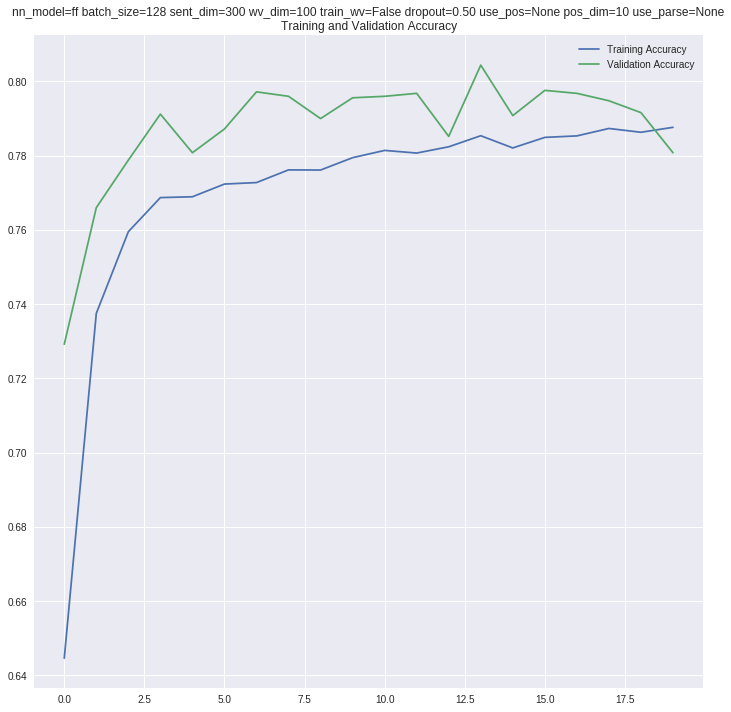

{'accuracy': 0.782, 'good': {'precision': 0.7656367746797287, 'recall': 0.8128, 'f1-score': 0.7885137757081878}, 'bad': {'precision': 0.8005115089514067, 'recall': 0.7512, 'f1-score': 0.775072224515064}}
           pred_good  pred_bad    total
true_good    10160.0    2340.0  12500.0
true_bad      3110.0    9390.0  12500.0
total        13270.0   11730.0      0.0


In [36]:
# model fit/train

# Sample of all possible settings:
# ---------------------------------
# dropout = 0.5
# epochs = 20
# pos_dim = 10
# batch_size = 128
# sent_dim = [200]
# nn_models = ['cnn', 'lstm', 'ff']
# train_wv = [False, True]
# use_pos = [None, 'embed', 'one_hot']
# use_parse = [None, 'filt']
# ---------------------------------

dropout = 0.5
epochs = 20
pos_dim = 10
batch_size = 128
sent_dim = [300]
nn_models = ['ff']
train_wv = [False]
use_pos = [None]
use_parse = [None]

experiment_wrapper = ExperimentWrapper()
exp_params = [ExperimentParameters(nn_model=nn, dropout=dropout, epochs=epochs, sent_dim=sd, pos_dim=10,
                                   batch_size=batch_size, train_wv=wvt, use_pos=upos, use_parse=uparse)
              for nn in nn_models for sd in sent_dim for wvt in train_wv for upos in use_pos for uparse in use_parse]

for ep in exp_params:
    experiment_wrapper.run(ExperimentData.from_df(df_train),
                           ExperimentData.from_df(df_dev),
                           ExperimentData.from_df(df_test), ep)